In [1]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import torch
import geoopt

from geoopt.optim import RiemannianSGD, RiemannianLineSearch
from landing_stiefel import LandingStiefelSGD
from plam import PLAMStiefelSGD

torch.manual_seed(0)

In [21]:
m = 10000        # Number of samples
n = 2000        # Dimension of samples
p = 1800          # Dimension of the subspace

batch_size = m

method_names = ["RiemannianSGD", "Landing", "Landing-ABB", "Landing-WNGrad"] #, "Landing", "Landing-WNGrad"]
methods =  [RiemannianSGD, LandingStiefelSGD, LandingStiefelSGD, LandingStiefelSGD]
learning_rates = [0.1, 0.1, 'ABB', 'WNGrad'] #'WNGrad']
ns_epochs = [200, 200, 200, 200]

lambda_regul = 1.0
safe_step = 0.5
#normalize_columns = False

device = 'cuda'

def generate_problem(m, n, p, sdev = 0):
    '''
    Generates A = L + N where L = U @ S @ V^T is a rank-r and 
    N is Gaussian noise
    '''
    U, _ = torch.linalg.qr(torch.randn(m,p), mode='reduced')
    V, _ = torch.linalg.qr(torch.randn(n,p), mode='reduced')
    S = torch.linspace(1, 0.5, steps=p)
    L = U @ S.diag() @ V.transpose(-1, -2)
    L = (L - L.mean(dim=0)) / L.std(dim=0) # zero mean, st. dev. one
    A = L + sdev * torch.randn(m,n)
    return A

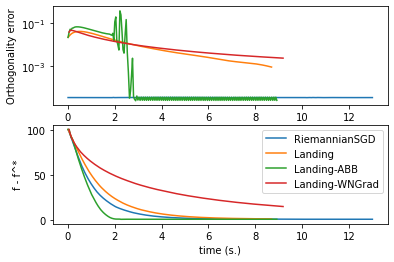

In [24]:
# generate random matrices
noise_level = 0
A = generate_problem(m, n, p, sdev=noise_level)        
A = A.to(device)

objective = lambda x : -.5 * (torch.matmul(A, x) ** 2).sum().item() / m

init_weights = torch.randn(n, p)

device = 'cuda'
A = A.to(device)
init_weights = init_weights.to(device)

# Compute the exact solution using SVD
_, _, vh = torch.linalg.svd(A, full_matrices = False)
x_star = vh[:p,:].T

# Objective: min -(1/2) * \| AX \|^2_F
loss_star = objective(x_star)

f, axes = plt.subplots(2, 1)
for method_name, method, n_epochs, learning_rate in zip(method_names, methods, ns_epochs, learning_rates):
    iterates = []
    loss_list = []
    time_list = []

    param = geoopt.ManifoldParameter(
        init_weights.clone(), manifold=geoopt.Stiefel(canonical=False)
    )
    with torch.no_grad():
        param.proj_()
    if method_name in ('Landing', 'PLAM'):
        optimizer = method((param,), lr=learning_rate, 
                        lambda_regul=lambda_regul, 
                        safe_step = safe_step)
    else:
        optimizer = method((param,), lr = learning_rate)
    
    t0 = time()
    for epoch in range(n_epochs):
        if method_name in ('RetractionLineSearch'):
            def closure():
                optimizer.zero_grad()
                idx = epoch % (m // batch_size)
                a = A[idx * batch_size: (idx + 1) * batch_size]
                loss = -.5 * (torch.matmul(a, param) ** 2).sum() / (batch_size)
                loss.backward()
                return loss.item()
            optimizer.step(closure)
        else:
            optimizer.zero_grad()
            idx = epoch % (m // batch_size)
            a = A[idx * batch_size: (idx + 1) * batch_size]
            loss = -.5 * (torch.matmul(a, param) ** 2).sum() / (batch_size)
            loss.backward()
            optimizer.step()
            
        time_list.append(time() - t0)
        loss_list.append(loss.item() - loss_star)
        iterates.append(param.data.clone())

    distance_list = []
    for matrix in iterates:
        d = (
            torch.norm(matrix.transpose(-1, -2).matmul(matrix) - torch.eye(p, device=matrix.device))
        )
        distance_list.append(d.item())
    axes[0].semilogy(time_list, distance_list, label=method_name)
    axes[1].semilogy(time_list, loss_list, label=method_name)

axes[0].set_xlabel("time (s.)")
axes[1].set_xlabel("time (s.)")
axes[0].set_ylabel("Orthogonality error")
axes[1].set_ylabel("f - f^*")
axes[1].set_yscale('linear')
plt.legend()
plt.savefig("plot_pca.pdf", dpi=150)
plt.show()